In [540]:
import numpy as np
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.formula.api import ols

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
# from statsmodels.api.graphics.tsa import plot_acf,plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import pmdarima as pm

In [248]:
ts=pd.read_excel('/Users/rickie/Desktop/statistics_by_python/time_series_data.xlsx')
ts.tail()

,日期,传统汽车销量,国内生产总值当季值(亿元)x1,汽油价格（元/吨）x2,人民币贷款基准利率%x3,汽车总产量（万辆）x4,新能源销量（万辆）x5,新能源产量（万辆x6）,公路里程数,汽车整车股票指数,消费者信心指数
60,2018年Q1,731.60,197920.0,7725,4.75,745.90,14.3,15.3,479.175,5916.325,122.866667
61,2018年Q2,648.78,219295.4,7780,4.75,675.68,26.9,27.9,481.000,5312.501,121.333333
62,2018年Q3,616.02,229495.5,8265,4.75,646.92,30.9,31.9,482.825,4877.138,118.933333
63,2018年Q4,694.33,253598.6,8755,4.75,747.83,53.5,54.5,484.650,4227.437,121.400000
64,2019年Q1,592.43,213432.8,7240,4.75,633.60,29.9,30.9,NaN,4661.423,123.700000


In [249]:
ts1=ts.set_index('日期')

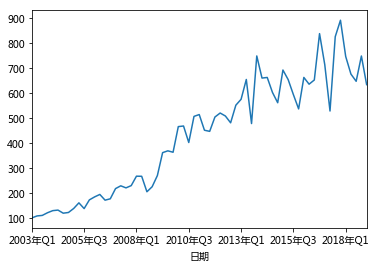

In [250]:
sales=ts1['汽车总产量（万辆）x4']
sales.plot()

,传统汽车销量,国内生产总值当季值(亿元)x1,汽油价格（元/吨）x2,人民币贷款基准利率%x3,汽车总产量（万辆）x4,新能源销量（万辆）x5,新能源产量（万辆x6）,公路里程数,汽车整车股票指数,消费者信心指数
2018-03-31,731.60,197920.0,7725.0,4.75,745.90,14.3,15.3,479.175,5916.325,122.866667
2018-06-30,648.78,219295.4,7780.0,4.75,675.68,26.9,27.9,481.000,5312.501,121.333333
2018-09-30,616.02,229495.5,8265.0,4.75,646.92,30.9,31.9,482.825,4877.138,118.933333
2018-12-31,694.33,253598.6,8755.0,4.75,747.83,53.5,54.5,484.650,4227.437,121.400000
2019-03-31,592.43,213432.8,7240.0,4.75,633.60,29.9,30.9,NaN,4661.423,123.700000


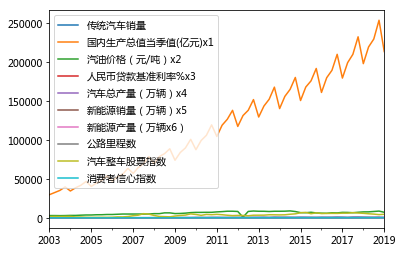

In [251]:
index=pd.date_range('2003-01-01','2019-04-01',freq='Q-DEC')#季度最后一个日历日的日期
ts=pd.DataFrame(ts1.values,index=index,columns=ts1.columns)
ts.plot()
ts.tail()

In [252]:
index=pd.date_range('2003-01-01','2019-04-01',freq='Q-DEC')#季度最后一个日历日的日期
sales=pd.Series(sales.values,index=index)
def stationary_test(df,n):
    rol_mean=pd.Series.rolling(df,window=n).mean()
    rol_std=pd.Series.rolling(df,window=n).std()
    plt.plot(df,label='Original')
    plt.plot(rol_mean,color='orange',label='rol_mean')
    plt.plot(rol_std,color='black',label='rol_std')
    plt.legend(loc='best')
    dftest=adfuller(df,autolag='AIC')#原假设是存在单位根，拒绝原假设则时间序列平稳
    result=pd.Series(dftest[:4],index=['Test Statistic','p-value','#lags used','Number of obervations used'])
    for k,v in dftest[4].items():
        result['critical value (%s):'%k]=v
    return result

In [253]:
#可以看到，数据的rolling均值/标准差具有越来越大的趋势，是不稳定的。
#且DF-test可以明确的指出，在任何置信度下，数据都不是稳定的。

Test Statistic                -1.001473
p-value                        0.752727
#lags used                     3.000000
Number of obervations used    61.000000
critical value (1%):          -3.542413
critical value (5%):          -2.910236
critical value (10%):         -2.592745
dtype: float64

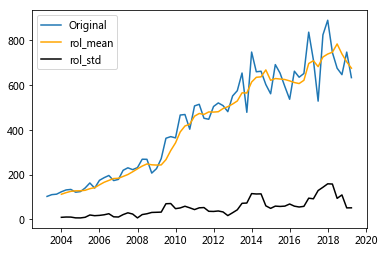

In [254]:
stationary_test(sales,4)

Test Statistic               -7.366595e+00
p-value                       9.201817e-11
#lags used                    3.000000e+00
Number of obervations used    5.700000e+01
critical value (1%):         -3.550670e+00
critical value (5%):         -2.913766e+00
critical value (10%):        -2.594624e+00
dtype: float64

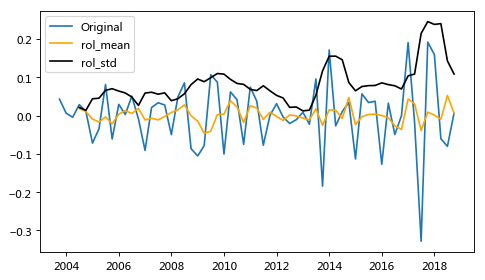

In [537]:
decomposition=seasonal_decompose(log_sales,freq=4)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
stationary_test(residual.dropna(),4)

Test Statistic               -7.346452e+00
p-value                       1.032580e-10
#lags used                    2.000000e+00
Number of obervations used    6.100000e+01
critical value (1%):         -3.542413e+00
critical value (5%):         -2.910236e+00
critical value (10%):        -2.592745e+00
dtype: float64

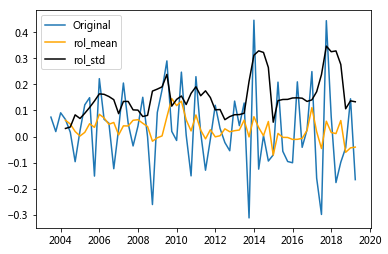

In [255]:
log_sales=np.log(sales)
# log_sales=sales
log_diff=log_sales.diff(1).dropna()
stationary_test(log_diff,4)
#拒绝df test的原假设，认为差分后的数据是平稳的

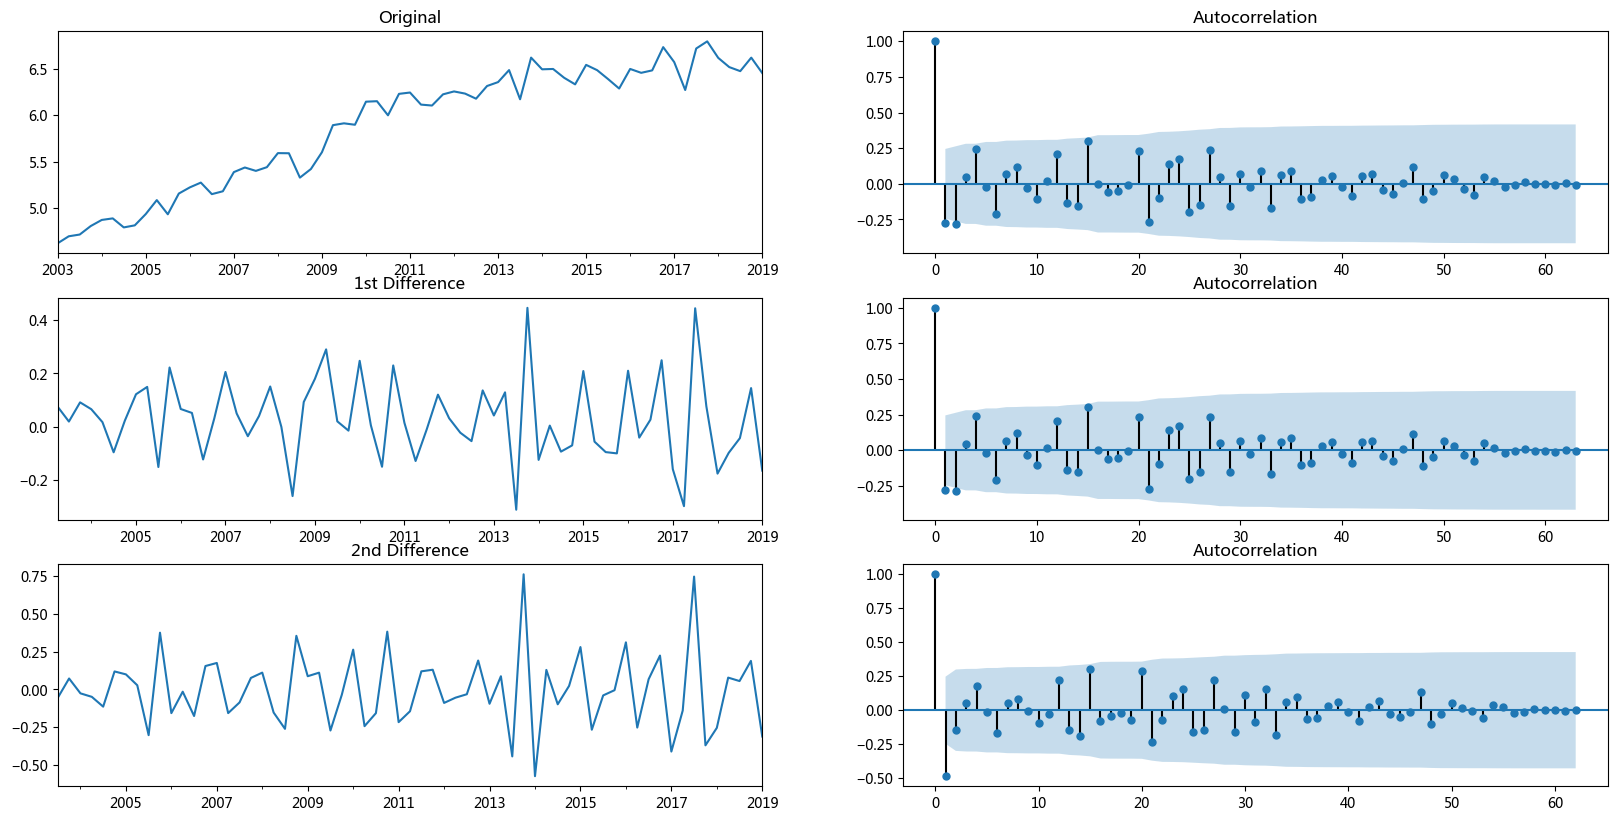

In [513]:
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':100})

fig,ax=plt.subplots(3,2)
log_sales.plot(ax=ax[0,0]);ax[0,0].set_title('Original')
plot_acf(log_diff,ax=ax[0,1])

log_diff.plot(ax=ax[1,0]);ax[1,0].set_title('1st Difference')
plot_acf(log_diff,ax=ax[1,1])

log_diff2=log_diff.diff().dropna()

log_diff2.plot(ax=ax[2,0]);ax[2,0].set_title('2nd Difference')
plot_acf(log_diff2,ax=ax[2,1])

plt.show()

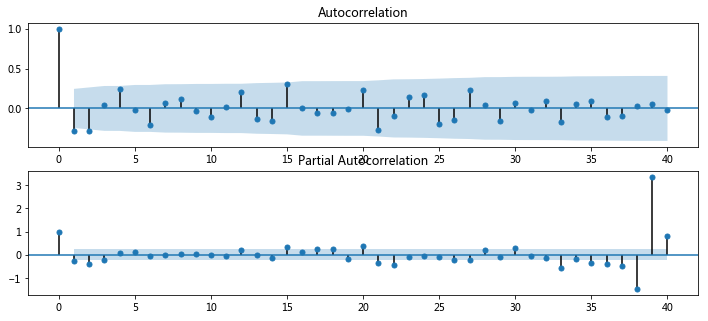

In [287]:
lag_acf=acf(log_diff,nlags=20)
lag_pacf=pacf(log_diff,nlags=20,method='ols')
fig = plt.figure(figsize=(12,5))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_diff,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_diff,lags=40,ax=ax2)

Text(0.5, 1.0, 'RSS: 1.2111')

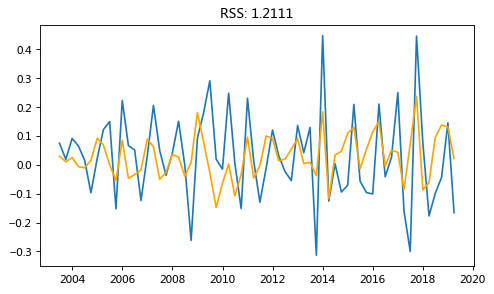

In [523]:
model2 = ARIMA(log_sales, order=(0, 1, 1))  
results_ARIMA2 = model2.fit(disp=-1)  #disp<0 means no output
plt.plot(log_diff)
plt.plot(results_ARIMA2.fittedvalues, color='orange')#fittedvalues是经过差分的？
plt.title('RSS: %.4f'% sum((results_ARIMA2.fittedvalues-log_diff)**2))

In [524]:
results_ARIMA2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   64
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  35.974
Method:                       css-mle   S.D. of innovations              0.138
Date:                Thu, 05 Mar 2020   AIC                            -65.947
Time:                        15:58:42   BIC                            -59.470
Sample:                    06-30-2003   HQIC                           -63.396
                         - 03-31-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0297      0.008      3.831      0.000       0.014       0.045
ma.L1.D.y     -0.5591      0.105     -5.324      0.000      -0.765      -0.353
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.7885           +0.0000j            1.7885            0.0000
-----------------------------------------------------------------------------
"""

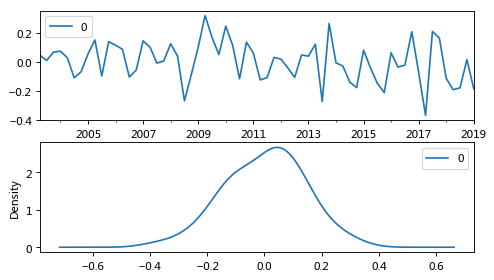

In [525]:
residual=pd.DataFrame(results_ARIMA2.resid)
# plt.figure(figsize=(12,3))
fig,ax=plt.subplots(2,1)
residual.plot(ax=ax[0]);residual.plot(kind='kde',ax=ax[1])

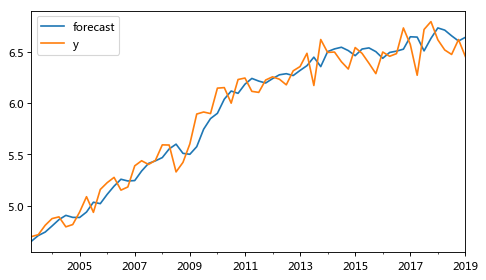

In [526]:
results_ARIMA2.plot_predict(dynamic=False)
plt.show()

/Users/rickie/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


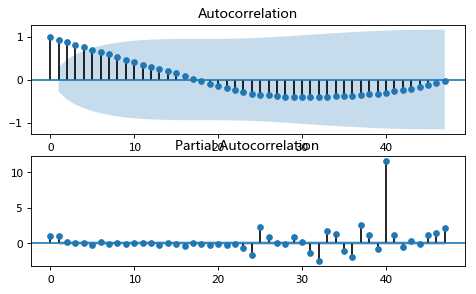

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   47
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  30.763
Method:                       css-mle   S.D. of innovations              0.125
Date:                Thu, 05 Mar 2020   AIC                            -55.526
Time:                        15:57:28   BIC                            -49.976
Sample:                    06-30-2003   HQIC                           -53.437
                         - 12-31-2014                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0383      0.008      4.748      0.000       0.022       0.054
ma.L1.D.y     -0.5745      0.155     -3.708      0.001      -0.878      -0.271
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.7406           +0.0000j            1.7406            0.0000
-----------------------------------------------------------------------------
"""

In [514]:
train=log_sales[:48]
test=log_sales[48:]
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':80})


fig,ax=plt.subplots(2,1)
plot_acf(train,ax=ax[0])
plot_pacf(train,ax=ax[1])
plt.show()

model=ARIMA(train,order=(0,1,1))
model_fit=model.fit(disp=-1)
model_fit.summary()

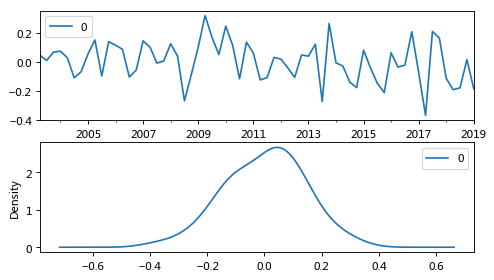

In [528]:
residual=pd.DataFrame(results_ARIMA2.resid)
# plt.figure(figsize=(12,3))
fig,ax=plt.subplots(2,1)
residual.plot(ax=ax[0]);residual.plot(kind='kde',ax=ax[1])

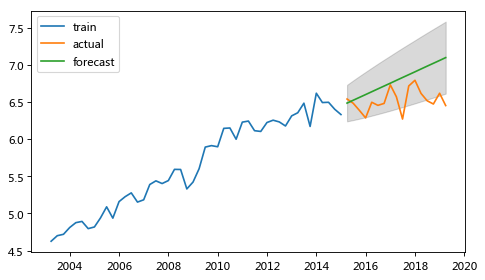

In [516]:
fc,se,cf=model_fit.forecast(17,alpha=0.05)
fc_series=pd.DataFrame(fc,index=test.index)
lower_series=pd.Series(cf[:,0],index=test.index)
upper_series=pd.Series(cf[:,1],index=test.index)

plt.plot(train,label='train')
plt.plot(test,label='actual')
plt.plot(fc_series,label='forecast')
plt.fill_between(lower_series.index,lower_series,upper_series,color='k',alpha=0.15)
plt.legend(loc='best')

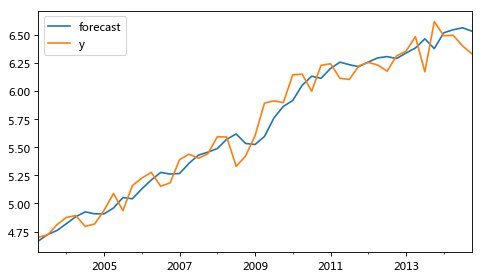

In [517]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [530]:
mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))  # MAPE Mean Absolute Percentage Error (MAPE)
mape

0.04247297194599159

In [548]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-48.424, BIC=-44.724, Time=0.016 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-50.943, BIC=-45.393, Time=0.051 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-55.526, BIC=-49.976, Time=0.060 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=-47.309, BIC=-45.459, Time=0.013 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-54.838, BIC=-47.438, Time=0.060 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-52.842, BIC=-43.592, Time=0.232 seconds
Total fit time: 0.442 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  30.763
Date:                Thu, 0

In [549]:
model.predict(5)

array([6.48446361, 6.52271463, 6.56096565, 6.59921666, 6.63746768])

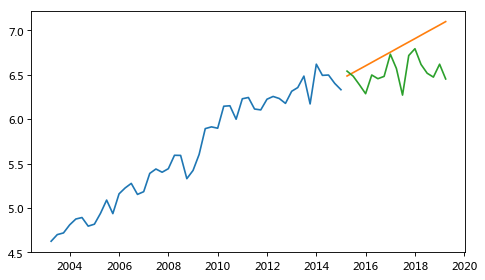

In [552]:
pred=pd.DataFrame(model.predict(len(test)),index=test.index)
plt.plot(train)
plt.plot(pred)
plt.plot(test)

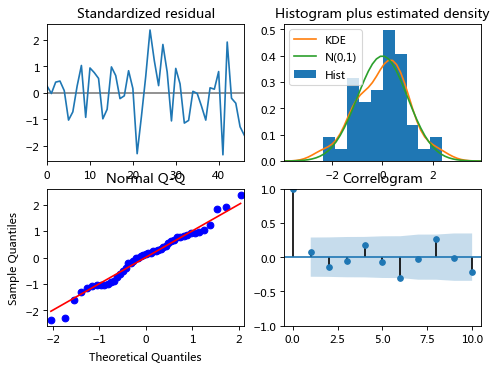

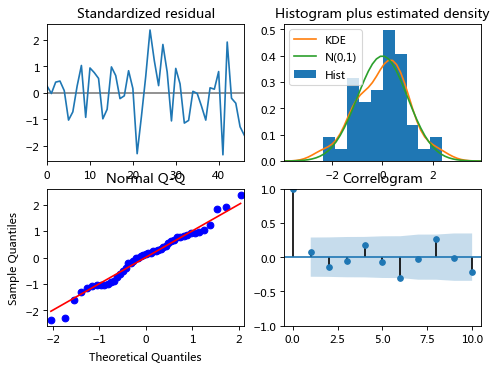

In [553]:
model.plot_diagnostics(figsize=(7,5))